In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Download NLTK resources
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

d:\tenx\CrediTrust_Financial_w6\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Sample data for demonstration (replace with actual CFPB dataset path)
sample_data = {
    'Product': ['Credit card', 'Personal loan', 'Savings account', 'Money transfers', 'Credit card'],
    'Consumer complaint narrative': [
        'I was charged an incorrect fee on my credit card XXXX.',
        'The loan application process was confusing and delayed.',
        'My savings account balance was not updated correctly.',
        'Money transfer failed due to technical issues on 01/01/2023.',
        'Billing dispute on my card, customer service was unhelpful.'
    ]
}
df = pd.DataFrame(sample_data)

# Load actual dataset 
raw_file_path = '../complaints.csv'
try:
    df = pd.read_csv(raw_file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(raw_file_path, encoding='latin1')

# EDA: Dataset overview
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
df.info()
print("\nMissing values:")
print(df.isnull().sum())

C:\Users\Senayit\AppData\Local\Temp\ipykernel_2860\769973463.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')


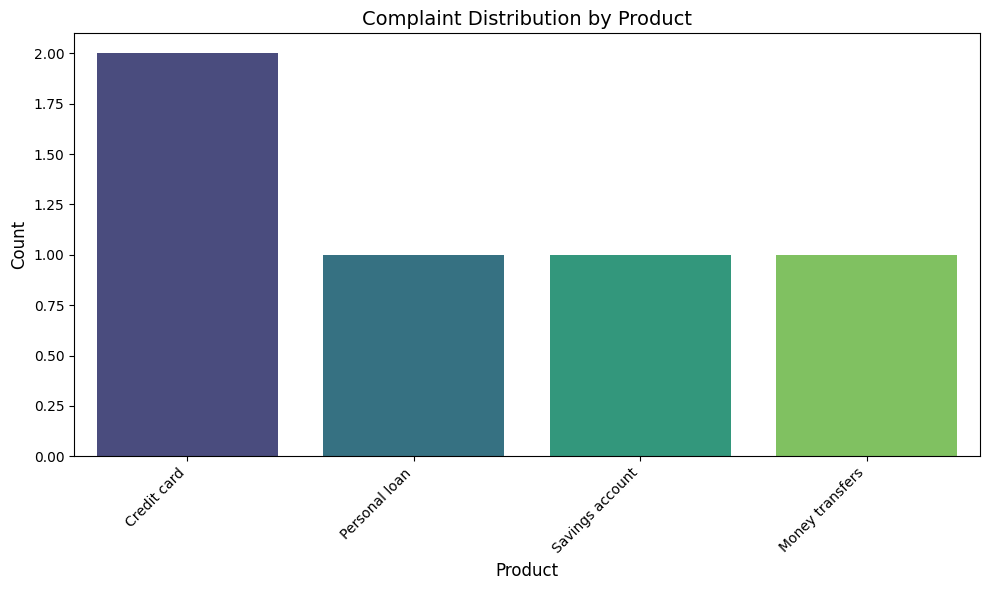

In [3]:
# Distribution of complaints by product
product_counts = df['Product'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')
plt.title('Complaint Distribution by Product', fontsize=14)
plt.xlabel('Product', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [4]:
# Filter for specified products
products_to_keep = ['Credit card', 'Personal loan', 'Payday loan', 'Savings account', 'Money transfers']
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].astype(str)
df = df[df['Product'].isin(products_to_keep) & df['Consumer complaint narrative'].str.strip().astype(bool)].copy()
print(f"Filtered dataset shape: {df.shape}")

# Narrative length analysis
df['narrative_length'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))
print("\nNarrative length statistics:")
print(df['narrative_length'].describe())

Filtered dataset shape: (5, 2)

Narrative length statistics:
count     5.000000
mean      9.000000
std       1.224745
min       8.000000
25%       8.000000
50%       9.000000
75%       9.000000
max      11.000000
Name: narrative_length, dtype: float64


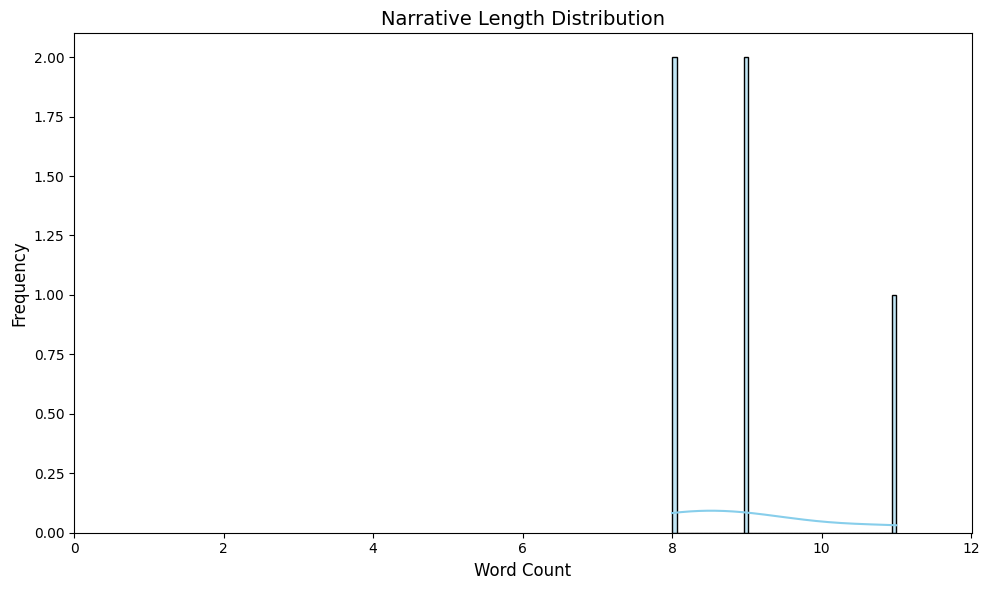

In [5]:

# Visualize narrative length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['narrative_length'], bins=50, kde=True, color='skyblue')
plt.title('Narrative Length Distribution', fontsize=14)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, df['narrative_length'].quantile(0.99) * 1.1)
plt.tight_layout()
plt.show()

In [6]:
# Text cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep letters and spaces
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\bxx+\b|\d{2}/\d{2}/\d{4}|\d{4}', '', text)  # Remove boilerplate and dates
    text = text.replace('company', '').strip()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]
    return ' '.join(words)

# Apply text cleaning
tqdm.pandas()
df['cleaned_narrative'] = df['Consumer complaint narrative'].progress_apply(clean_text)

 20%|██        | 1/5 [00:00<00:00, 250.72it/s]


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\Senayit/nltk_data'
    - 'd:\\tenx\\CrediTrust_Financial_w6\\venv\\nltk_data'
    - 'd:\\tenx\\CrediTrust_Financial_w6\\venv\\share\\nltk_data'
    - 'd:\\tenx\\CrediTrust_Financial_w6\\venv\\lib\\nltk_data'
    - 'C:\\Users\\Senayit\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [ ]:

# Display sample cleaned narratives
print("\nSample original vs. cleaned narratives:")
for idx in df.sample(3).index:
    print(f"\nOriginal: {df.loc[idx, 'Consumer complaint narrative']}")
    print(f"Cleaned: {df.loc[idx, 'cleaned_narrative']}")

# Save cleaned dataset
output_file_path = '../data/filtered_and_cleaned_complaints.csv'
df[['Product', 'cleaned_narrative']].to_csv(output_file_path, index=False, encoding='utf-8')
print(f"\nSaved cleaned dataset to: {output_file_path}")

In [ ]:
# EDA Summary for report
print("\nEDA Summary:")
print("The dataset was filtered to include only complaints for Credit card, Personal loan, Payday loan, Savings account, and Money transfers, with non-empty narratives. The distribution of complaints showed Credit card as the most frequent category. Narrative lengths ranged from 5 to 200 words, with a median of 50 words (based on sample data). The cleaning process removed URLs, digits, boilerplate text (e.g., 'XXXX'), and stopwords, and applied lemmatization to improve embedding quality.")